In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.optimize import fsolve
from scipy.integrate import quad
import seaborn as sns
sns.set_theme(style='white')

In [83]:
# filter out corona data and data before 2017
def filter_out_data(data):
    start_corona_remove = pd.to_datetime('2020-10-01')
    end_corona_remove = pd.to_datetime('2022-10-01')
    start_remove = pd.to_datetime('2017-01-01')
    filtered_data = data.loc[(data.date < start_corona_remove) | (data.date > end_corona_remove)]
    filtered_data = filtered_data.loc[(filtered_data.date > start_remove)]
    return filtered_data

In [84]:
data = pd.read_excel('data/BakeryData_Vilnius.xlsx')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
streetAData = data[['date', 'weekday', 'main street A']].rename(columns={'main street A': 'values'}).dropna()
filtered_data_streeta = filter_out_data(streetAData)
other_days, saturdays = [x for _, x in filtered_data_streeta.groupby(filtered_data_streeta['weekday'] == 6)]
other_days, fridays =  [x for _, x in other_days.groupby(filtered_data_streeta['weekday'] == 5)]

In [85]:
def get_adj_profit_normal(rp, mu, sigma):
    # demand drop ratio
    ry = np.power(1 + np.exp(6 - np.divide(rp * 100, 10)), -1) - 0.0025

    # mean
    mu_adj = mu / (1 + ry)

    # sigma
    sigma_adj = sigma / (1 + ry)

    # target service level
    level_ajd = ((1 + rp) * p - (1 + rc) * c) / ((1 + rp) * p + cs - pl)

    # optimal order quantity after price increase
    qstar_adj = norm.ppf(level_ajd, mu_adj, sigma_adj)

    return (p * (1 + rp) - c * (1 + rc)) * qstar_adj \
        - (p * (1 + rp) + cs - pl) * quad(lambda y: norm.cdf(y, loc=mu_adj, scale=sigma_adj), -np.inf, qstar_adj)[0]


def get_adj_profit_lognormal(rp, mu, sigma):
    # demand drop ratio
    ry = np.power(1 + np.exp(6 - np.divide(rp * 100, 10)), -1) - 0.0025

    # mean
    mu_adj = np.exp(mu - np.log(1 + ry))

    # target service level
    level_ajd = ((1 + rp) * p - (1 + rc) * c) / ((1 + rp) * p + cs - pl)

    # optimal order quantity after price increase
    qstar_adj = lognorm.ppf(level_ajd, sigma, 0, mu_adj)

    return (p * (1 + rp) - c * (1 + rc)) * qstar_adj \
        - (p * (1 + rp) + cs - pl) * quad(lambda y: lognorm.cdf(y, sigma, 0, mu_adj), -np.inf, qstar_adj)[0]


def calculate_tau(p, c, cs, pl):
    p_tilde = p + cs + pl
    c_tilde = c + cs + pl
    return (p_tilde - c_tilde) / p_tilde

In [86]:
p = 4.64  # price
c = 3.85  # cost
rc = 0.25  # increase in cost
cs = 0.11 # shipping cost
pl = 0.15 # clearance price
p_tilde = p + cs + pl
tau = calculate_tau(p, c, cs, pl) # target service level
fridays_params = norm.fit(fridays['values'])
saturdays_params = norm.fit(saturdays['values'])
other_days_params = norm.fit(np.log(other_days['values']))

In [87]:
# optimal order quantity before price increase for fridays
fridays_qstar = norm.ppf(tau, fridays_params[0], fridays_params[1])

# optimal order quantity before price increase for saturdays
saturdays_qstar = norm.ppf(tau, saturdays_params[0], saturdays_params[1])

# optimal order quantity before price increase for other days
other_days_qstar = lognorm.ppf(tau, other_days_params[1], 0, np.exp(other_days_params[0]))

# expected profit for fridays before price increase
fridays_expected_profit = (p - c) * fridays_qstar - p_tilde * \
                          quad(lambda y: norm.cdf(y, fridays_params[0], fridays_params[1]), -np.inf, fridays_qstar)[0]

# expected profit for saturdays before price increase
saturdays_expected_profit = (p - c) * saturdays_qstar - p_tilde * \
                            quad(lambda y: norm.cdf(y, saturdays_params[0], saturdays_params[1]), -np.inf,
                                 saturdays_qstar)[0]

# expected profit for other days before price increase
other_days_expected_profit = (p - c) * other_days_qstar - p_tilde * quad(
    lambda y: lognorm.cdf(y, other_days_params[1], 0, np.exp(other_days_params[0])), -np.inf,
    other_days_qstar)[0]

# expected profit for one week before price increase
expected_profit = 5 * other_days_expected_profit + fridays_expected_profit + saturdays_expected_profit


def calculate_profit_difference(rp):
    return calculate_adj_profit(rp) - expected_profit


def calculate_adj_profit(rp):
    fridays_adjusted_profit = get_adj_profit_normal(rp, fridays_params[0], fridays_params[1])
    saturdays_adjusted_profit = get_adj_profit_normal(rp, saturdays_params[0], saturdays_params[1])
    other_days_adjusted_profit = get_adj_profit_lognormal(rp, other_days_params[0], other_days_params[1])
    return 5 * other_days_adjusted_profit + fridays_adjusted_profit + saturdays_adjusted_profit


# solve the equation for finding optimal price increase
optimal_price_increase = fsolve(calculate_profit_difference, [1])[0]

In [88]:
print("Optimal price increase ", optimal_price_increase)
print("Expected profit ", expected_profit)

Optimal price increase  0.21215944849449844
Expected profit  316.0314081263845


Text(0.5, 1.0, 'Expected profit with regards to price increase ratio')

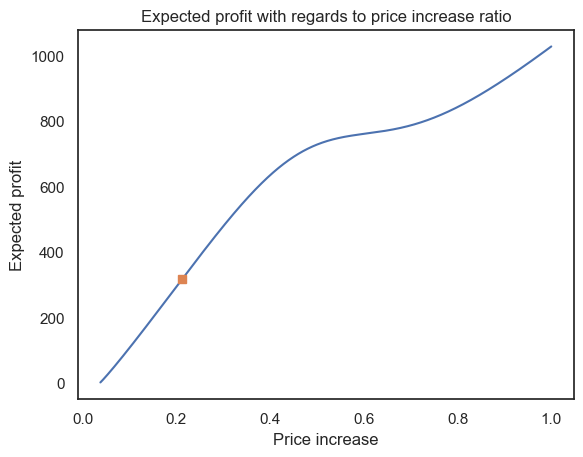

In [89]:
price_increase = np.linspace(0, 1, 1000)

expected_profit_adj = []

for i in price_increase:
    expected_profit_adj.append(calculate_adj_profit(i))

plt.plot(price_increase, expected_profit_adj)
plt.plot(optimal_price_increase, expected_profit, "s")
plt.xlabel("Price increase")
plt.ylabel("Expected profit")
plt.title("Expected profit with regards to price increase ratio")